<a href="https://colab.research.google.com/github/DrAlexSanz/amld2021-unsupervised/blob/master/Alex_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/DonErnesto/amld2021-unsupervised/blob/master/notebooks/solutions_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Solution: Demonstration of several algorithms on the Pen Digits dataset

Exercises using the Pen Digits Dataset: https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/literature/PenDigits/PenDigits_v01.html

The data consists of a .csv files, created by recording the writing pattern (x and y's) of digits on a digital writing pad. The digit "4" is downsampled to only 20 instances (instead of ~1000 for the other points), making it an outlier. 

Note that (unlike MNIST) the features are not pixel values, but are x,y subsampled coordinate pairs, for a total of 8 pairs. 

This dataset is small and simple: it has only numeric features and no NaN's.

# **This is a training dataset. Normally I wouldn't have labels.**

# Package installing and data import

In [19]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab, need to get data and install libraries..')
    data_path = './'
    # Now only load the required files...
    !curl -O https://raw.githubusercontent.com/DrAlexSanz/amld2021-unsupervised/master/notebooks/outlierutils.py
    !curl -O https://raw.githubusercontent.com/DrAlexSanz/amld2021-unsupervised/master/data/x_pendigits.csv
    !curl -O https://raw.githubusercontent.com/DrAlexSanz/amld2021-unsupervised/master/data/y_pendigits.csv
    !pip install --upgrade pyod
else:
    print('Not running on CoLab, data and libraries are already present')
    data_path = '../data'


Running on CoLab, need to get data and install libraries..
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13595  100 13595    0     0   228k      0 --:--:-- --:--:-- --:--:--  228k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  761k  100  761k    0     0  8103k      0 --:--:-- --:--:-- --:--:-- 8103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19744  100 19744    0     0   127k      0 --:--:-- --:--:-- --:--:--  127k


## Imports

In [6]:
# Library imports
import os

import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

I'm importing two helper functions, for easy plotting:
* plot_top_N:
  * Plots the actual binary labels (Positive versus Negative) of the N points
    with the highest outlier scores.
  * Takes y_true (labels), the scores and N.

* plot_outlier_scores:
  * Plots the distributions.
  * Takes the y_trues and the scores.

In [7]:
from outlierutils import plot_top_N, plot_outlier_scores # For easy plotting and evaluation

## Data loading

In [27]:
from sklearn.preprocessing import MinMaxScaler # Originally it was StandardScaler, I prefer MinMaxScaler because data shouldn't be a Normal distribution.
x_pen_raw = pd.read_csv('x_pendigits.csv')
y_pen = pd.read_csv('y_pendigits.csv')['outlier']

# Scale and put again into a DataFrame before doing anything.
sc = MinMaxScaler()
x_pen = pd.DataFrame(data=sc.fit_transform(x_pen_raw))

In [21]:
print(f'Number of points: {len(y_pen)}')
print(f'Number of positives: {y_pen.sum()} ({y_pen.mean():.3%})')

Number of points: 9868
Number of positives: 20 (0.203%)


## Show some of the data without scaling.

If I use standard scaler I will plot very strange figures

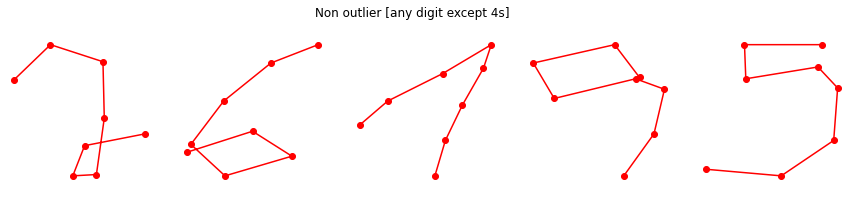

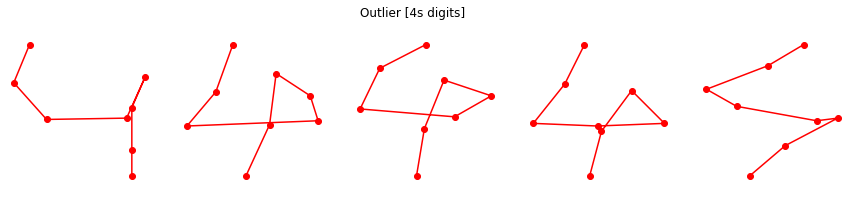

In [28]:
non_outlier = y_pen[y_pen == 0]
outlier = y_pen[y_pen == 1]  

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs = axs.ravel()
for ax, i in enumerate([15, 4, 1, 8, 1234]):
    xcoor = x_pen_raw.iloc[non_outlier.index[i], :].values.reshape([8,2])
    axs[ax].plot(xcoor[:,0], xcoor[:,1],'ro-')
    axs[ax].axis('equal')
    axs[ax].axis('off')
fig.suptitle('Non outlier [any digit except 4s]')

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs = axs.ravel()
for ax, i in enumerate(range(5)):
    xcoor = x_pen_raw.iloc[outlier.index[i], :].values.reshape([8,2])
    axs[ax].plot(xcoor[:,0], xcoor[:,1],'ro-')
    axs[ax].axis('equal')
    axs[ax].axis('off')
fig.suptitle('Outlier [4s digits]');

## Visualization with t-SNE

In [29]:
from sklearn.manifold import TSNE

N_downsample = 3000
assert x_pen.index.equals(y_pen.index), 'Error, indexes differ. Reset them to continue'
x_downsampled = pd.concat((x_pen[y_pen==0].sample(N_downsample - int(y_pen.sum()), random_state=1),
                           x_pen[y_pen==1]), 
                          axis=0).sample(frac=1, random_state=1)
y_downsampled = y_pen[x_downsampled.index]

In [36]:
MAX_N_TSNE = 3500 #Avoid overly long computation times with TSNE. Values < 5000 recommended 
neg = y_downsampled == 0
pos = y_downsampled == 1

assert len(x_downsampled) <= MAX_N_TSNE, f'Using a dataset with more than {MAX_N_TSNE} points is not recommended'
X_2D = TSNE(n_components=2, 
            perplexity=50, 
            n_iter=400,
           random_state=5).fit_transform(x_downsampled) 


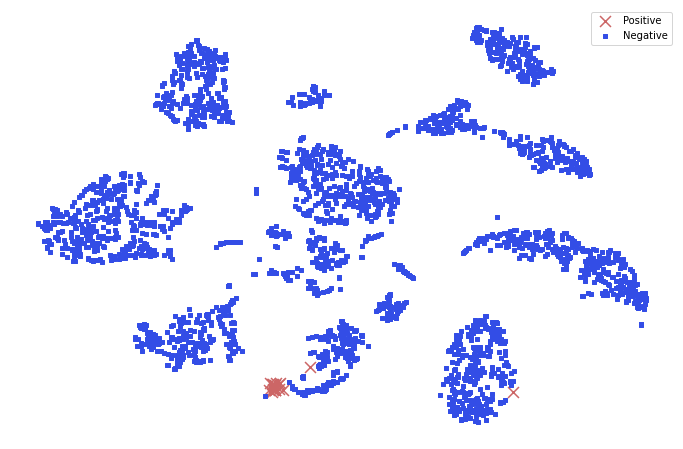

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(X_2D[pos, 0], X_2D[pos, 1], c=[[0.8, 0.4, 0.4],], marker='x', s=120, label='Positive')
ax.scatter(X_2D[neg, 0], X_2D[neg, 1], c=[[0.2, 0.3, 0.9],], marker='s', s=10, label='Negative')

plt.axis('off')
plt.legend()
plt.show() 

### Some observations:
- Depending on the perplexity, we see roughly 10 clusters, not all well-defined. This is in line with the expectation to see 9 + 1 (the 9 digits plus "4", the undersampled outlier class)
- The outlier class forms a single cluster, rather than being scattered across
- This corresponds to our understanding of the data: the outlier class is really an under-represented class

### How about PCA?

I can see a few clusters but it doesn't capture the underlying structure of the data.

In [38]:
from sklearn.decomposition import PCA

PCA_2D = PCA(n_components = 2).fit_transform(x_downsampled)

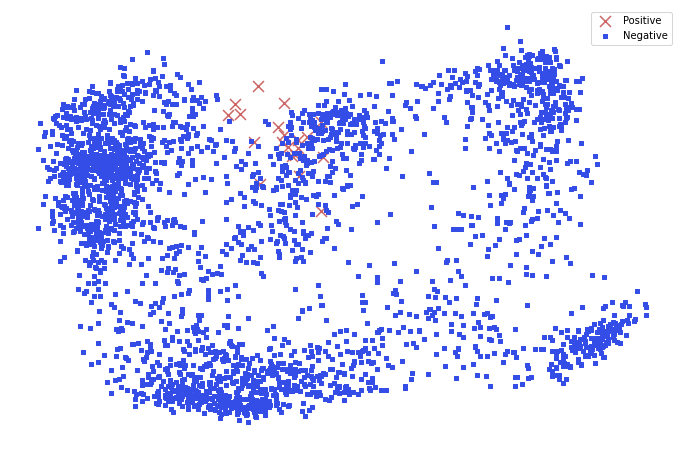

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(PCA_2D[pos, 0], PCA_2D[pos, 1], c=[[0.8, 0.4, 0.4],], marker='x', s=120, label='Positive')
ax.scatter(PCA_2D[neg, 0], PCA_2D[neg, 1], c=[[0.2, 0.3, 0.9],], marker='s', s=10, label='Negative')

plt.axis('off')
plt.legend()
plt.show() 

## Mahalanobis Distance

Generalized distance. 

For culture, we can calculate the Mahalonobis distance in two ways:
- Directly: Calculating the Covariance matrix (with the full data, or with the robust MinCovDet), then the Mahalonobis distance
- Indirectly: Do a whitened PCA decompose with full-rank, calculate the Euclidean distance

We will take the first option:

In [63]:
from sklearn.covariance import MinCovDet, EmpiricalCovariance

cov_ = EmpiricalCovariance().fit(x_pen)
#cov_ = MinCovDet().fit(x_pen) # Numerically robust estimation. Totally unnecessary and worse results.
mahalonobis_scores = cov_.mahalanobis(x_pen)
mahalonobis_scores = np.clip(mahalonobis_scores, 0, 60)

In [64]:
print(sorted(mahalonobis_scores[:-15]))

[4.065133886112154, 4.645168536976967, 4.7833332783217815, 4.786535998530186, 4.895331556263285, 4.9577266145434615, 4.967421257824649, 5.062430462268244, 5.074567799909395, 5.076420953578636, 5.083879938106622, 5.0905454539876525, 5.139322442110958, 5.204057017786608, 5.20935534674735, 5.2277154259124305, 5.248992436989322, 5.24929894510099, 5.30359664307677, 5.318867383752715, 5.333850103594926, 5.383512725005198, 5.400350726211874, 5.417456312335392, 5.422907022015369, 5.424667763189764, 5.4271917960970475, 5.438946676686856, 5.4749325789021555, 5.477373389492365, 5.497113243300376, 5.5042450132992995, 5.5190154657424975, 5.536823365273824, 5.5456380683105415, 5.58718045557924, 5.588315349523566, 5.594429078229467, 5.608311234557032, 5.624925203219023, 5.657603685803038, 5.66746224141774, 5.721728615938494, 5.737857545949883, 5.752634646413601, 5.761068875814096, 5.782091811190154, 5.7864450556038936, 5.787992034587425, 5.7909854357548864, 5.807870776584811, 5.811607732703099, 5.824

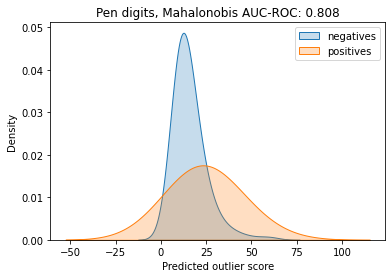

In [65]:
res = plot_outlier_scores(y_pen, mahalonobis_scores, bw_adjust=4, title='Pen digits, Mahalonobis')

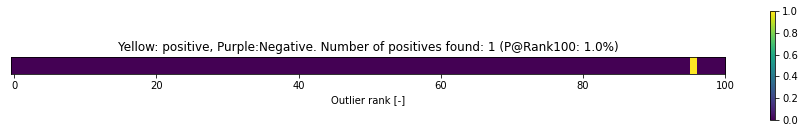

In [62]:
res = plot_top_N(y_pen.values, mahalonobis_scores)

### Mahalonobis results

**AUC-ROC-score: 0.81, P@100 1%**

* I get 0.81 as AUC, not bad for a simple method.
* The positives at 100 is the number of outliers that I found in the first 100 points. I should have 20 outliers with the highest scores and 80 inliers below. I only found 1 and it's in position 90 something, so this method is easy to implement and fast to calculate but not too accurate.

## GMM

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=9, covariance_type='full', random_state=1) # try also spherical
gmm.fit(x_pen, )
gmm_scores = - gmm.score_samples(x_pen)

In [ ]:
gmm_scores = np.clip(gmm_scores, -15, 50)

In [ ]:
res = plot_outlier_scores(y_pen, gmm_scores, bw_adjust=4, title='Pen digits, Mahalonobis (GMM)')

In [ ]:
res = plot_top_N(y_pen.values, gmm_scores)

In [ ]:
labels_ds = gmm.predict(x_downsampled)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

n_components = gmm.n_components
for i, class_ in enumerate(range(n_components)):
    idx = np.where(labels_ds == i)[0]
    idx_pos = np.where((labels_ds == i) & (pos.values))[0]
    
    c=[(0.8-0.8*(i/n_components), 0.4 + 0.2*(i%2), 0.2+0.75*(i/n_components)), ]
    ax.scatter(X_2D[idx, 0], X_2D[idx, 1], c=c, 
               marker='o', s=10, label=f'class {i}')
    if len(idx_pos):
        ax.scatter(X_2D[idx_pos, 0], X_2D[idx_pos, 1], c=c, 
           marker='x', s=200, label=f'Positive, class {i}')     

plt.axis('off')
plt.legend()
plt.show() 
    

##### GMM results (n=9)

Generally, most outliers are a minority fraction of the same cluster. This looks like a less coherent cluster (points unrelated in t-SNE). 

GMM agrees with t-SNE on most clusters. 
AUC-ROC-score 0.96, P@100 2%

#### A 1 
GMM performs clearly better. The reason is that the model fits the data (which consists of ~10 separate clusters) better

In [ ]:
from sklearn.metrics import roc_auc_score

n_components_list = list(range(3, 15))
gmm_scores_list = [GaussianMixture(n_components=i, covariance_type='full', random_state=1).fit(x_pen).score_samples(x_pen)
 for i in n_components_list]# try also spherical
gmm_roc_scores = [roc_auc_score(y_pen, - y_pred_) for y_pred_ in gmm_scores_list]

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_components_list, gmm_roc_scores, 'b-x', label='ROC AUC [-]')
ax.set_xlabel('N clusters')
ax.set_ylabel('ROC scores');

## K-nearest neighbours

Use the scikit-learn NearestNeighbors implementation to get neighbor statistics and outlier scores



#### A 2.1
The probability of the nearest neighbour of a point being an outlier, conditional on the class membership of that point:

In [ ]:
from sklearn.neighbors import NearestNeighbors

# First: verify that the nearest neighbours of outliers are usually outliers (as one may expect from the TSNE plot)
clf_nn = NearestNeighbors(n_neighbors=21) # NB: the first neighbour is the point itself
clf_nn.fit(x_pen)
Nth_neighbour = 20
distances, indices = clf_nn.kneighbors(x_pen)
nearest_ns = indices[:, Nth_neighbour]

print(f'Fraction of {Nth_neighbour}st neighbor that is an outlier, conditional on y==1: {y_pen[nearest_ns[y_pen==1]].mean():.2%}')      
print(f'Fraction of {Nth_neighbour}st neighbor that is an outlier, conditional on y==0: {y_pen[nearest_ns[y_pen==0]].mean():.2%}')

The first neighbour of an outlier is an outlier in 90% of the cases. Even the 10th neigbour is an outlier in more than 50 %. Indeed, as observed in t-SNE, outliers are close together in this case. 


#### A 2.2 Use pyod to get outlier scores

In [ ]:
from pyod.models.knn import KNN

# train kNN detector
n_neighbours = 31

clf = KNN(method='largest', n_neighbors=n_neighbours)
clf.fit(x_pen)
# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
knn_scores = clf.decision_scores_  # raw outlier scores

In [ ]:
res = plot_outlier_scores(y_pen, knn_scores, bw_adjust=0.2, 
                          title=f'Pen digits, KNN. (n={n_neighbours})')

In [ ]:
res = plot_top_N(y_pen.values, knn_scores)

##### KNN results

With k=31, ROC-score is 0.98, and P@100 is 8.0% (8 positives) 

#### A 3
Comparing scores for a range of n_neighbors

In [ ]:
from sklearn.metrics import roc_auc_score

def calc_precision_at_100(scores):
    return y_pen[np.argsort(scores)][::-1][:100].mean()

    
n_neighbour_list = [1+i*5 for i in range(20)]
knn_scores_list = [KNN(method='median', n_neighbors=n).fit(x_pen).decision_scores_
                  for n in n_neighbour_list]

knn_roc_auc_scores = [roc_auc_score(y_pen, knn_score) for knn_score in knn_scores_list]
knn_precision_at_100 = [calc_precision_at_100(knn_score) for knn_score in knn_scores_list]


In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(n_neighbour_list, knn_roc_auc_scores, 'b-x', label='ROC AUC [-]')
ax2.plot(n_neighbour_list, knn_precision_at_100, 'r-x', label='Precision@100')
ax.set_xlabel('N neighbours');
ax.set_ylabel('AUC score', color='b');
ax2.set_ylabel('Precision@100', color='r');
ax2.set_ylim([0, 0.2])
ax.legend()
ax2.legend()
ax.set_title('KNN results');

Optimal k is about 30 (both AUC-ROC and p@100). 

Precision@100 is much stronger affected by n_neighbours than the AUC-ROC score.  

Choosing `n_neighbours` too high leads to a dilution of the scores and a strong decrease in the top-100 precision.

## 3. LOF

#### A 4.

LOF compares the "reachability-density" of an object to the average density of its neighbours. The reachability-density is an inverse of the reachability distance, which puts a lower limit on the distance between two points that is given on the distance of the kth-nearest neighbour. Points that are part of one cluster all have a similar density, and thus get a score of around 1. An isolated point has a much lower density than its nearest neighbour when that neighbour is part of a dense cluster, and gets a high outlier score. 

Since in the pendigits data outliers are clustered together, they may easily have comparable densities. Thus, when the value for K is too small (smaller than the cluster size), the algorithm will not detect differences in densities, and fail to recognize the outliers. 

LOF with k=10 can thus be expected to perform worse than KNN. 

https://en.wikipedia.org/wiki/Local_outlier_factor



**Example 1:** N_neighbours = 10

In [ ]:
from pyod.models.lof import LOF

n_neighbours = 10
lof = LOF(n_neighbors=n_neighbours, contamination=0.01)
lof.fit(x_pen)
lof_scores = lof.decision_scores_
res = plot_outlier_scores(y_pen, lof_scores, 
                          bw_adjust=0.04, title=f'Pen digits, LOF. (n={n_neighbours})')

**Example 2:** N_neighbours = 50

In [ ]:
n_neighbours = 50
lof = LOF(n_neighbors=n_neighbours, contamination=0.01)
lof.fit(x_pen)
lof_scores = lof.decision_scores_

res = plot_outlier_scores(y_pen, lof_scores, 
                          bw_adjust=0.04, title=f'Pen digits, LOF. (n={n_neighbours})')

#### A 5.
n_neighbours of about 50 seems suitable. Clearly, it needs to be larger than the number of outliers (in the original data), since these form a single cluster. 


**Extra: compare scores for a range of n_neighbors**

In [ ]:
# Loop over a range of n_neighbours
n_neighbour_list = [1+i*5 for i in range(20)]
lof_scores_list = [LOF(n_neighbors=n).fit(x_pen).decision_scores_
                  for n in n_neighbour_list]

In [ ]:
lof_roc_auc_scores = [roc_auc_score(y_pen, score) for score in lof_scores_list]

N_ = 100
lof_precision_at_N = [y_pen[np.argsort(score)][::-1][:N_].mean() for score in lof_scores_list]


In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(n_neighbour_list, lof_roc_auc_scores, 'b-x', label='ROC AUC [-]')
ax2.plot(n_neighbour_list, lof_precision_at_N, 'r-x', label=f'Precision@{N_}')
ax.set_xlabel('N neighbours');
ax.set_ylim([0.75, 1])
ax.set_ylabel('AUC score', color='b');
ax2.set_ylabel(f'Precision@{N_}', color='r');
ax2.set_ylim([0, 0.2])

ax.set_title('LOF results');

##### LOF results

Note that LOF requires indeed a large n_neighbours to spot the outliers (for the AUC metric), whereas this dilutes the results, giving a worse precision@100. 

LOF is clearly less suited to this particular dataset. 


With k=10, LOF has a ROC score of 0.59, which is hardly better than random guessing. 

With k=50 ROC is 0.93. P@100 is optimal at low k (max 2%), whereas ROC requires k=50
 or larger.


## Isolation Forest


#### A 6.

Isolation Forest makes splits in an orthogonal fashion. This means it is not rotationally invariant, and it will generate artefacts (points being easier to split in one of the axis directions).  

Running with n_estimators=1000 and 1024 samples is generally okay. 

In [ ]:
from pyod.models.iforest import IForest

ifo = IForest(n_estimators=1000, max_samples=1024, random_state=1, contamination=0.01, behaviour='new')
ifo.fit(x_pen)
# NB: in contradiction to the documentation, there is no .decision_scores_ attribute for iForest
iforest_scores = ifo.decision_scores_ #ifo.decision_function(x_pen) 

In [ ]:
res = plot_outlier_scores(y_pen, iforest_scores, bw_adjust=0.02, title='Pen digits (Isolation Forest)')

In [ ]:
res = plot_top_N(y_pen.values, iforest_scores, N=100)

#### Results isolation Forest

AUC-ROC score 0.88, P@rank100 is 0

#### A 4.3 (Optional)
Running several isoForest's and comparing scores

Note the rather large variation of AUC ROC scores for `n_estimators`=100, by doing 10 calculations with different random seeds:

In [ ]:
from sklearn.ensemble import IsolationForest

n_estimators=100
ifo_clfs = [IsolationForest(n_estimators=n_estimators, max_samples=512, 
                            random_state=i, contamination=0.01)
            .fit(x_pen) for i in range(10)]
ifo_roc_scores = [roc_auc_score(y_pen.values, -ifo_clf.decision_function(x_pen)) for ifo_clf in ifo_clfs]

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('AUC (ROC)')
sns.swarmplot(ifo_roc_scores, ax=ax);
ax.set_title(f'Scatter in AUC, n estimators {n_estimators}');


**original** outliers: 

With 100 trees: between 0.80 and 0.88

With 1000 trees: between 0.83 and 0.86

## 5. PCA reconstruction error

#### A. 7

This is actually not an easy question at all. One may look at the explained variance ratio, but there is no golden rule for a cut-off here either. This is a parameter that can not be intuitively chosen (unlike the k in kNN). 


In [ ]:
from sklearn.decomposition import PCA
from pyod.models.pca import PCA as pyod_PCA

# NBA: the pyod PCA is implemented differently, and does not seem to work as intended 
# pca = pyod_PCA(n_components=5, weighted=False, n_selected_components=5, standardization=True).fit(x_pen)
# pca.fit(x_pen)
# pca_scores = pca.decision_scores_

In [ ]:
pca = PCA(n_components=16, whiten=False)
pca_tf = pca.fit_transform(x_pen)
plt.bar(x=range(1, 17), height=1 - pca.explained_variance_ratio_.cumsum());
plt.ylabel('Average relative reconstruction error');
plt.xlabel('Number of components');

In [ ]:
pca = PCA(n_components=8, whiten=False)
pca_tf = pca.fit_transform(x_pen)
x_pen_recon = pca.inverse_transform(pca_tf)
pca_scores = ((x_pen - x_pen_recon)**2).mean(axis=1).values
#pca_scores = np.clip(pca_scores, 0, 200) # clip for plotting purposes

In [ ]:
res = plot_outlier_scores(y_pen, pca_scores, bw_adjust=0.04, title='Pen digits, Mahalonobis (Through PCA)')

In [ ]:
res = plot_top_N(y_pen.values, pca_scores, N=100)

In [ ]:
n_components_list = []
recon_error_list = []
auc_list = []
for i, n_components in enumerate(range(1, 15)):
    pca = PCA(n_components=n_components, whiten=False)
    pca_tf = pca.fit_transform(x_pen)
    x_pen_recon = pca.inverse_transform(pca_tf)
    pca_scores_ = ((x_pen - x_pen_recon)**2).mean(axis=1).values
    recon_error_list.append(1 - pca.explained_variance_ratio_[-1])
    n_components_list.append(n_components)
    auc_list.append(roc_auc_score(y_pen, pca_scores_))
 

In [ ]:
plt.plot(recon_error_list, auc_list)
for x, y, text in zip(recon_error_list, auc_list, n_components_list):
    plt.text(x, y, text)
plt.xlabel('Explained variance ratio')
plt.ylabel('AUC score');
plt.title('Explained variance ratio and AUC as f(n_components)');

#### A. 8
PCA scores: 

Best results PCA (n_components 8): AUC-ROC score 0.89, P@rank100 is 0

## 6. Autoencoder

#### A. 9

Since the data is not bounded between (-1, 1), and may become negative as well as positive, we can't use a sigmoid or (r)elu activation function. A linear activation function is the correct choice. 


In [ ]:
from pyod.models.auto_encoder import AutoEncoder

clf = AutoEncoder(
    hidden_neurons=[10, 8, 10],
    hidden_activation='elu',
    output_activation='linear',
    optimizer='adam',
    epochs=15,
    batch_size=16,
    dropout_rate=0.0,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=False, #NB: this uses sklearn's StandardScaler
    verbose=1,
    random_state=1,
    contamination=0.1,
)

In [ ]:
clf.fit(x_pen)


In [ ]:
autoenc_scores = clf.decision_scores_  # raw outlier scores
res = plot_outlier_scores(y_pen, autoenc_scores, bw_adjust=0.2, title='Pen digits, Autoencoder outlier scores')

In [ ]:
res = plot_top_N(y_pen.values, autoenc_scores)

**Extra: check the reconstruction error visually**

In [ ]:
positive_idx = list(y_pen[y_pen==1].index)[:3]
negative_idx = list(y_pen[y_pen==0].index)[:3]

In [ ]:
# Compare the original with the reconstruction to get a feeling (in StandardScaled space)
def show_reconstruction(clf, data, index, ax, title=''):
    if isinstance(data, pd.DataFrame):
        data = data.values
    data_recon = clf.model_.predict(data[[index], :])
    ax.plot(data[index, :], label='original')
    ax.plot(data_recon[0, :], label='reconstructed', linestyle='--');
    ax.legend()
    ax.set_title(title);

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16, 7))
titles = ['Outlier', 'Inlier']
for i, idxs in enumerate([positive_idx, negative_idx]):
    for j, idx in enumerate(idxs):
        score = '{:.3f}'.format(autoenc_scores[idx])
        show_reconstruction(clf, x_pen, index=idx, ax=axs[i, j], title=titles[i]  + f' (index {idx}, score {score})'
                            )

#### Autoencoder results 

With (10, 8, 10) ROC score 0.87, P@rank100 is 1%

Make a matrix with all the results


In [ ]:
scores_dict = {'mahalanobis':mahalonobis_scores,
                'knn':knn_scores,
               'lof':lof_scores,
               'gmm':gmm_scores,
               'iforest':iforest_scores,
               'pca':pca_scores,
               'autoenc':autoenc_scores}

results_dict= {'auc-roc':{alg:roc_auc_score(y_pen, score) for alg, score in scores_dict.items()},}
results_df = pd.DataFrame(results_dict).sort_values(by='auc-roc', ascending=False)

In [ ]:
results_df.round(2)

In [ ]:
results_df.loc[:, 'auc-roc'].plot(kind='bar')
plt.title('AUC-ROC scores');

#### A. 10

For this dataset the best algorithms are KNN and the GMM. 
Both these algorithms require a single parameter, which may be possible to estimate (number of neighbours, number of clusters). In both cases, the algorithms are pretty robust with respect to the exact parameter value. 

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_pen, knn_scores)
plt.plot(recall[:-1], precision[:-1]);
plt.xlabel('Recall');
plt.ylabel('Precision');

### Extra:  DBSCAN

In [ ]:
def make_dbscan_outlierscore(labels):
    """ Returns outlier scores from db scan labels
    The -1 cluster are defined as outliers, and get the highest outlier score
    Other clusters: the smaller the cluster, the larger the outlier score
    
    labels (np.ndarray) : cluster labels
    
    Returns: outlier_scores (np.ndarray)
    """
    cluster_counter = Counter(labels)
    del cluster_counter[-1] # Outliers will get score 1 at the end
    cluster_label, cluster_size = (np.array(list(cluster_counter.keys())), 
                                   np.array(list(cluster_counter.values())))
    
    cluster_order = cluster_label[np.argsort(cluster_size)][::-1]
    scores = np.array(range(len(cluster_label))) / len(cluster_label)
    cluster_mapping = {c:s for c, s in zip(cluster_order, scores)}
    cluster_mapping = {**cluster_mapping, -1:1}
    outlier_scores = np.vectorize(cluster_mapping.get)(labels)
    return outlier_scores
    
    

DBSCAN has two parameters to choose. min_samples has a smaller influence than epsilon. Larger epsilon results in fewer clusters. A somewhat smaller epsilon (resulting in ~10 clusters) seems beneficial. 

In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter

db = DBSCAN(eps=1.5, min_samples=10)
db.fit(x_pen)

In [ ]:
db_outlier_scores = make_dbscan_outlierscore(db.labels_)

In [ ]:
len(np.unique(db.labels_))

In [ ]:
res = plot_outlier_scores(y_pen, db_outlier_scores, bw_adjust=0.075, title='Pen digits, Mahalonobis (Through PCA)')

In [ ]:
res = plot_top_N(y_pen.values, db_outlier_scores, N=100)

In [ ]:
roc_scores_dbscan = {eps: roc_auc_score(y_pen.values, 
                                        make_dbscan_outlierscore(DBSCAN(eps=eps, min_samples=10)
                                                                 .fit(x_pen)
                                                                 .labels_)) 
                     for eps in  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]}

In [ ]:
plt.plot(list(roc_scores_dbscan.keys()), list(roc_scores_dbscan.values()), '-x');
plt.xlabel('Epsilon value')
plt.ylabel('AUC')
plt.title('DBSCAN: epsilon versus Area under ROC curve');

### Extra: OCSVM

In [ ]:
from pyod.models.ocsvm import OCSVM

In [ ]:
ocsvm_clf = OCSVM(gamma='auto', kernel='rbf')
ocsvm_clf.fit(x_pen)
ocsvm_scores = ocsvm_clf.decision_scores_

In [ ]:
res = plot_outlier_scores(y_pen, ocsvm_scores)

In [ ]:
scores_df = pd.DataFrame()
scores_df['knn_scores'] = knn_scores
scores_df['gmm_scores'] = gmm_scores
scores_df['lof_scores'] = lof_scores
scores_df['iforest_scores'] = iforest_scores
scores_df['autoenc_scores'] = autoenc_scores
scores_df['dbscan_scores'] = db_outlier_scores
scores_df['ocsvm_scores'] = ocsvm_scores
scores_df['mahalonobis_scores'] = mahalonobis_scores

sns.pairplot(scores_df);
